# 1: Introduction

Over the last two missions, we began investigating possible relationships between SAT scores and demographics. In order to do this, we acquired several data sets containing information about New York City public schools. We cleaned them, then combined them into a single data set named combined that we're now ready to analyze and visualize.

In this mission, we'll discover correlations, create plots, and then make maps. The first thing we'll do is find any correlations between any of the columns and sat_score. This will help us determine which columns might be interesting to plot out or investigate further. Afterwards, we'll perform more analysis and make maps using the columns we've identified.

# 2: Finding Correlations With the r Value

Correlations tell us how closely related two columns are. We'll be using the r value, also called Pearson's correlation coefficient, which measures how closely two sequences of numbers are correlated.

An r value falls between -1 and 1. The value tells us whether two columns are positively correlated, not correlated, or negatively correlated. The closer to 1 the r value is, the stronger the positive correlation between the two columns. The closer to -1 the r value is, the stronger the negative correlation (i.e., the more "opposite" the columns are). The closer to 0, the weaker the correlation. To learn more about r values, see the [statistics course](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).

The columns in the following diagram have a strong positive correlation -- when the value in class_size is high, the corresponding value in sat_score is also high, and vice versa:

| sat_score | avg_class_size   |
|-----------|------------------|
|   2000    | 200              |
|   4000    | 400              |
|   5000    | 490              |
|   6000    | 610              |
|   7000    | 700              |
|   8000    | 800              |

The r value for the columns in the diagram above is .99.

The columns in the following diagram have a strong negative correlation -- when the value in class_size is high, the corresponding value in sat_score is low, and when the value in sat_score is high, the value in class_size is low:

| sat_score | avg_class_size   |
|-----------|------------------|
|   2000    | 800              |
|   4000    | 700              |
|   5000    | 690              |
|   6000    | 490              |
|   7000    | 400              |
|   8000    | 200              |

The r value for the columns in the diagram above is -.99.

In the next diagram, the columns aren't correlated -- class_size and sat_score don't have any strong pattern in their values:

| sat_score | avg_class_size   |
|-----------|------------------|
|   2000    | 400              |
|   4000    | 400              |
|   5000    | 590              |
|   6000    | 490              |
|   7000    | 500              |
|   8000    | 500              |

The r value for the columns in the diagram above is -.02, which is very close to 0.

In general, r values above .25 or below -.25 are enough to qualify a correlation as interesting. An r value isn't perfect, and doesn't indicate that there's a correlation -- just the possiblity of one. To really assess whether or not a correlation exists, we need to look at the data using a scatterplot to see its "shape." For example, here's a scatterplot with a very strong negative r value of -.73:

<img src='correlation.png'>

Notice how in the image above, all of the points appear to fall along a line. This pattern indicates a correlation.

Here's a scatterplot with an r value of .15, which indicates a weak correlation:

<img src='no_correlation.png'>

Notice how the data points in the image go in several directions, and there's no clear linear relationship. We'll explore correlations in greater detail later on in the statistics content. For now, this quick primer should be enough to get us through this project.

Because we're interested in exploring the fairness of the SAT, a strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. If men tended to score higher on the SAT, for example, that would indicate that the SAT is potentially unfair to women.

We can use the pandas pandas.DataFrame.corr() method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original data set.

# pre steps preparing data

In [8]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("../data/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
all_survey = pandas.read_csv("../data//survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("../data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# ADD DBN COLS
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# CONVERT COLS TO NUMERIC
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")
    
# Combine the datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


# 3: Finding Correlations With the r Value

## Instructions

    Use the pandas.DataFrame.corr() method on the combined dataframe to find all possible correlations. Assign the result to correlations.
    Filter correlations so that it only shows correlations for the column sat_score.
    Display all of the rows in correlations and look them over.
    

In [9]:
correlations = combined.corr()
print ( correlations['sat_score'] )

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# 4: Plotting Enrollment With the Plot() Accessor

On the last screen, you should have seen output that looked like above cell



The numbers above represent the r value between the sat_score column and the named column. The numbers are in scientific notation, which is a system for representing numbers with many decimal places more easily. For example, 9.868201e-01 is scientific notation for .9868201, 4.294755e-02 is notation for .04294755, and -3.969849e-01 is notation for -.3969849. The number after the e- just means "move the decimal point this many places to the left."

Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score.

We can also make some other observations:

    total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
        Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
    Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
    Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
    Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
    There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
    The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

Because enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score. Each point in the scatterplot will represent a high school, so we'll be able to see if there are any interesting patterns.

We can plot columns in a dataframe using the pandas.DataFrame.plot() accessor on a dataframe. We can also specify a certain plot type. For example, df.plot.scatter(x="A", y="b") will create a scatterplot of columns A and B.

# 5: Plotting Enrollment With the Plot() Accessor

## Instructions

    Create a scatterplot of total_enrollment versus sat_score.

 Need a hint?

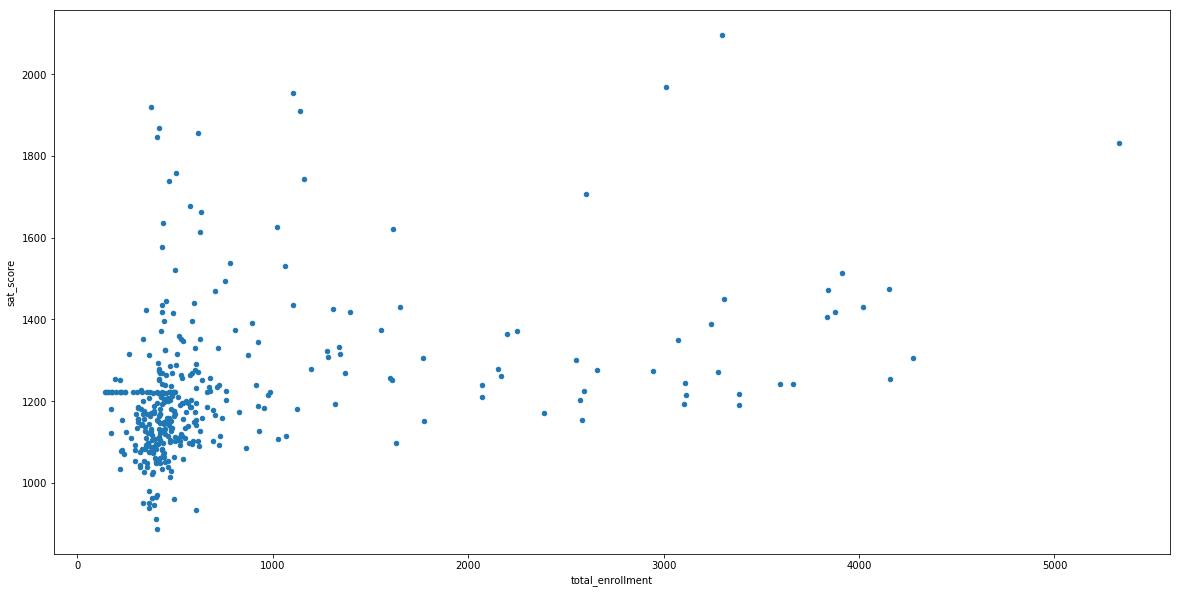

In [12]:
import matplotlib.pyplot as plt
 
combined.plot.scatter(x="total_enrollment", y="sat_score", figsize=( 20, 10 ) )
plt.show()

# 6: Exploring Schools With Low SAT Scores and Enrollment

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.
Instructions

    Filter the combined dataframe to keep only those rows where total_enrollment is under 1000 and sat_score is under 1000. Assign the result to low_enrollment.
    Display all of the items in the School Name column of low_enrollment.
    Use Wikipedia and Google to research the names of the schools. Can you discover anything interesting about them?


# 7: Plotting Language Learning Percentage

Our research on the last screen revealed that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, let's plot out ell_percent vs sat_score.
Instructions

    Create a scatterplot of ell_percent versus sat_score.

 Need a hint?

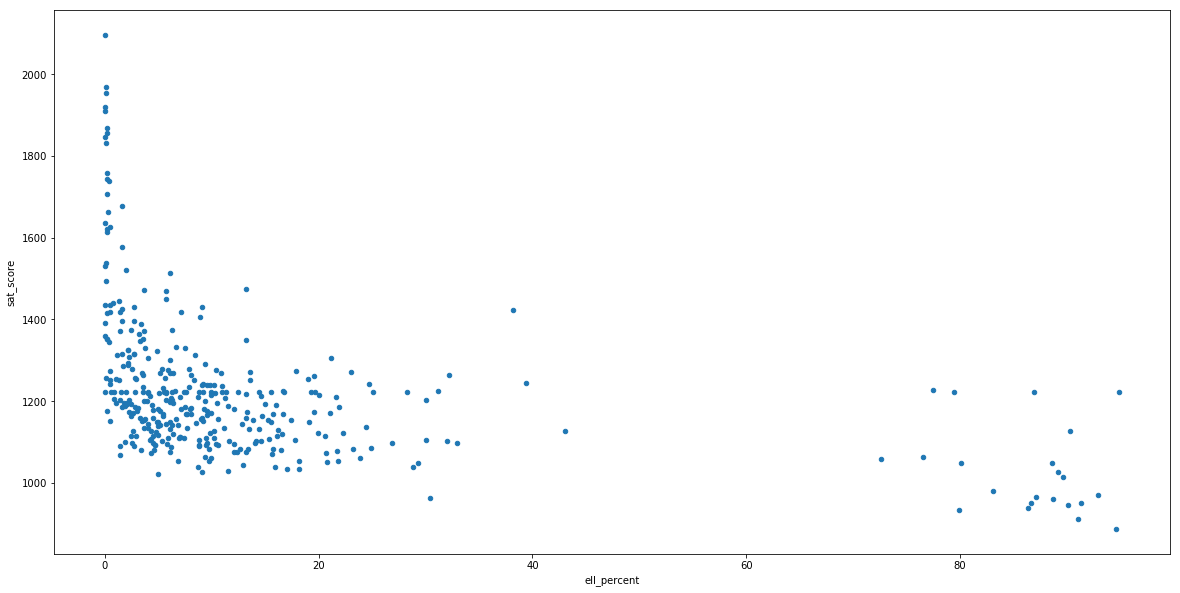

In [15]:
combined.plot.scatter(x="ell_percent", y="sat_score", figsize=( 20, 10 ) )
plt.show()

# 8: Mapping the Schools With Basemap

It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there's still the cluster of schools that have very high ell_percent values and low sat_score values. This cluster represents the same group of international high schools we investigated earlier.

In order to explore this relationship, we'll want to map out ell_percent by school district. The map will show us which areas of the city have a lot of English language learners.

We learned how to use the Basemap package to create maps in the Visualizing Geographic Data mission. The Basemap package enables us to create high-quality maps, plot points over them, and then draw coastlines and other features.

We extracted the coordinates for all of the schools earlier, and stored them in the lat and lon columns. The coordinates will enable us to plot all of the schools on a map of New York City.

We can set up the map with this code:

    from mpl_toolkits.basemap import Basemap

    m = Basemap(
        projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )

    m.drawmapboundary(fill_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawrivers(color='#6D5F47', linewidth=.4)

This code snippet will create a map that centers on New York City (llcrnrlat, urcrnrlat, llcrnrlon, and urcrnrlon define the corners of the geographic area the map depicts). It will also draw coastlines and rivers accordingly.

Now all we need to do is convert our lat and lon coordinates to x and y coordinates so we can plot them on top of the map. This will show us where all of the schools in our data set are located.

As you may recall, in order to plot coordinates using Basemap, we need to:

    Convert the pandas series containing the latitude and longitude coordinates to lists using the pandas.Series.tolist() method.
    Make a scatterplot using the longitudes and latitudes with the scatter() method on the Basemap object.
    Show the plot using the pyplot.show() method.

We also need to make sure we pass a few keyword arguments to the scatter() method:

    s - Determines the size of the point that represents each school on the map.
    zorder - Determines where the method draws the points (that represent schools) on the z axis. In other words, it determines the order of the layers on the map. If we set zorder to 2, the method will draw the points on top of the continents, which is where we want them.
    latlon - A Boolean value that specifies whether we're passing in latitude and longitude coordinates instead of x and y plot coordinates.


# 9: Mapping the Schools With Basemap

## Instructions

    Set up the map using the code snippet you saw above -- the one that creates a map, then draws rivers, coastlines, and boundaries.
    Convert the lon column of combined to a list, and assign it to the longitudes variable.
    Convert the lat column of combined to a list, and assign it to the latitudes variable.
    Call the Basemap.scatter() method on m, and pass in longitudes and latitudes as arguments.
        Make sure to pass in longitudes and latitudes in the correct order.
        Pass in the keyword argument s=20 to increase the size of the points in the scatterplot.
        Pass in the keyword argument zorder=2 to plot the points on top of the rest of the map. Otherwise the method will draw the points underneath the land.
        Pass in the keyword argument latlon=True to indicate that we're passing in latitude and longitude coordinates, rather than axis coordinates.
    Show the plot using the pyplot.show() method.

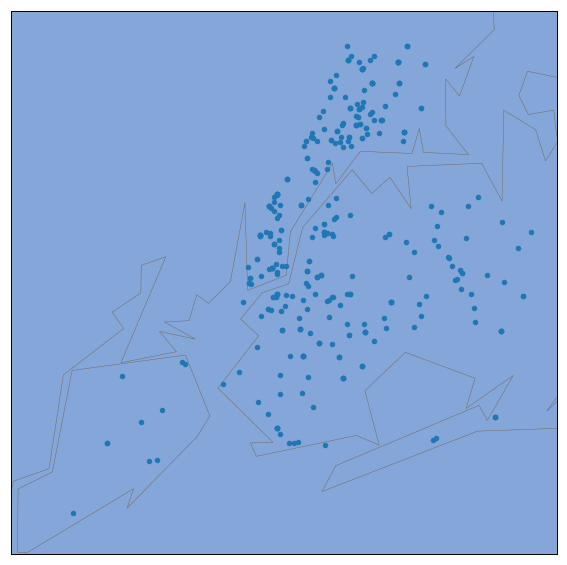

In [19]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

plt.figure( figsize=( 10, 10  ) ) 

m.drawmapboundary( fill_color='#85A6D9' )
m.drawcoastlines( color='#6D5F47', linewidth=.4 )
m.drawrivers( color='#6D5F47', linewidth=.4 )

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter( longitudes, latitudes, s=20, zorder=2, latlon=True )
plt.show()

# 10: Plotting Out Statistics

From the map above, we can see that school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island.

Now that we've plotted the school locations, we can begin to display meaningful information on the maps, such as the percentage of English language learners by area.

We can shade each point in the scatterplot by passing the keyword argument c into the scatter() method. This argument accepts a variable containing a sequence of numbers, assigns different colors to those numbers, and then shades the points on the plot associated with those numbers accordingly.

The method will convert the sequence of numbers we pass into the c keyword argument to values ranging from 0 to 1. It will then map these values onto a colormap. Matplotlib has quite a few default colormaps. In our case, we'll use the summer colormap, which results in green points for low numbers, and yellow points for high numbers.

For example, let's say we plotted ell_percent by school. If we pass in the keyword argument c=combined["ell_percent"], then the method would shade a school with a high ell_percent yellow, and a school with a low ell_percent green. We can specify the colormap we want to use by passing the cmap keyword argument to the scatter() method.
Instructions

    Set up the map using the code snippet that creates a map, then draws rivers, coastlines, and boundaries.
    Call the scatter() method on m, and pass in longitudes and latitudes as arguments.
        Make sure to pass in longitudes and latitudes in the correct order.
        Pass in the keyword argument s=20 to increase the size of the points in the scatterplot.
        Pass in the keyword argument zorder=2 to plot the points on top of the rest of the map. Otherwise the method will draw the points underneath the land.
        Pass in the keyword argument latlon=True to indicate that we're passing in latitude and longitude coordinates, rather than axis coordinates.
        Pass in the keyword argument c with the value combined["ell_percent"] to plot the ell_percent.
        Pass in the keyword argument cmap="summer" to get the right color scheme.
    Show the plot using the show() method.


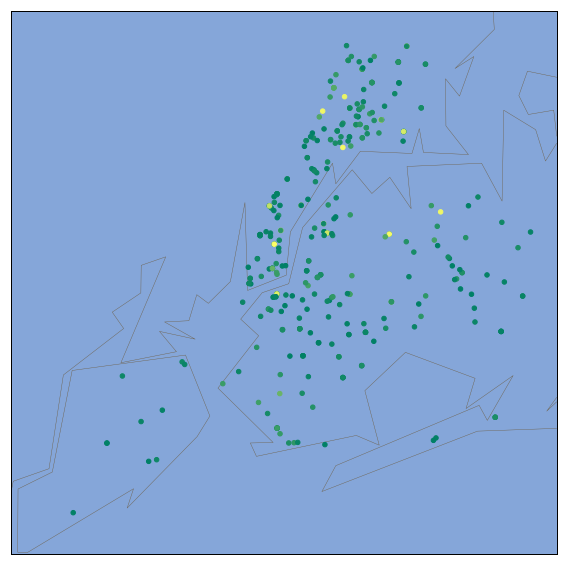

In [21]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

plt.figure( figsize=( 10, 10  ) ) 

m.drawmapboundary( fill_color='#85A6D9' )
m.drawcoastlines( color='#6D5F47', linewidth=.4 )
m.drawrivers( color='#6D5F47', linewidth=.4 )

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter( longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer" )

plt.show()

# 11: Calculating District-Level Statistics

Unfortunately, due to the number of schools, it's hard to interpret the map we made on the last screen. It looks like uptown Manhattan and parts of Queens have a higher ell_percent, but we can't be sure. One way to make very granular statistics easier to read is to aggregate them. In this case, we can aggregate by district, which will enable us to plot ell_percent district-by-district instead of school-by-school.

In the last mission, we used the pandas.DataFrame.groupby() followed by the agg() method on the resulting object to find the mean class size for each unique DBN. The principle is exactly the same, except that here we'd find the mean of each column for each unique value in school_dist.

## Instructions

    Find the average values for each column for each school_dist in combined.
        Use the pandas.DataFrame.groupby() method to group combined by school_dist.
        Use the agg() method, along with the numpy.mean function as an argument, to calculate the average of each group.
        Assign the result to the variable districts.
    Reset the index of districts, making school_dist a column again.
        Use the pandas.DataFrame.reset_index() method with the keyword argument inplace=True.
    Display the first few rows of districts to verify that everything went okay.


In [22]:
import numpy

districts = combined.groupby( "school_dist" ).agg( numpy.mean )
districts.reset_index( inplace=True )
districts.head( 5 )

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


# 12: Plotting Percent Of English Learners by District

Now that we've taken the means of all of the columns, we can plot out ell_percent by district. Not only did we find the mean of ell_percent, but we also took the means of the lon and lat columns, which will give us the coordinates for the center of each district.

## Instructions

    Use the code snippet from before that creates a map, then draws rivers, coastlines, and boundaries.
    Convert the lon column of districts to a list, and assign it to the longitudes variable.
    Convert the lat column of districts to a list, and assign it to the latitudes variable.
    Call the scatter() method on m, and pass in longitudes and latitudes as arguments.
        Make sure to pass in longitudes and latitudes in the correct order.
        Pass in the keyword argument s=50 to increase the size of the points in the scatterplot.
        Pass in the keyword argument zorder=2 to plot the points on top of the rest of the map. Otherwise the method will draw the points underneath the land.
        Pass in the keyword argument latlon=True to indicate that we're passing in latitude and longitude coordinates, rather than axis coordinates.
        Pass in the keyword argument c with the value districts["ell_percent"] to plot the ell_percent.
        Pass in the keyword argument cmap="summer" to get the right color scheme.
    Show the plot using the show() method.

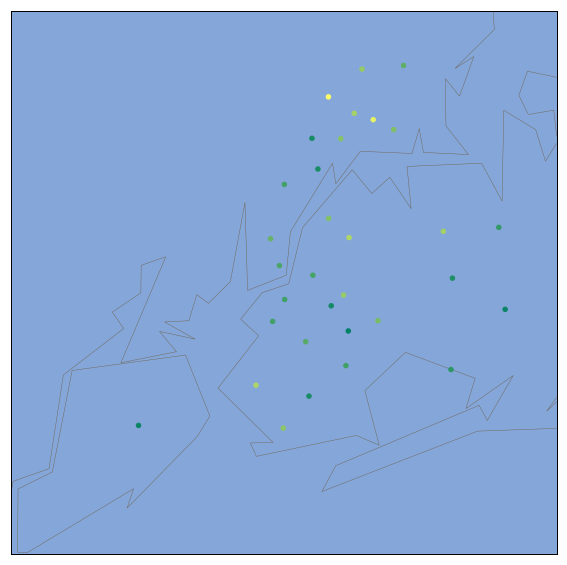

In [23]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

plt.figure( figsize=( 10, 10 ))
m.drawmapboundary( fill_color='#85A6D9' )
m.drawcoastlines( color='#6D5F47', linewidth=.4 )
m.drawrivers( color='#6D5F47', linewidth=.4 )

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter( longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer" )

plt.show()

# 13: Next Steps

In this mission, we found correlations, created visualizations, and mapped out our schools! Now we have all the tools we need to analyze the data in greater depth.

Along the way, we learned:

    How to create school and district-level maps
    How to find correlations, and what those correlations mean
    Why we should plot data out, rather than relying on the r value alone
    That ell_percent has a strong negative correlation with sat_score

We now have the skills to analyze data sets and explain the quirks we find. These are essential skills for any data science professional.

Next, we'll use the skills and tools we've developed to analyze the New York City high school data more fully in a guided project.